2D Classification

In [1]:
import os
import numpy as np
import pandas as pd
import pydicom as dicom
import cv2
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
DATA_DIR = 'Data/'
LABELS_CSV = 'LungCT-Labels - Sheet1.csv'
IMG_SIZE_PX = 150
SLICE_COUNT = 20

In [ ]:
def load_data(data_dir, labels_df, img_size_px=IMG_SIZE_PX, hm_slices=SLICE_COUNT):
    image_full_data = []
    
    patients = os.listdir(data_dir)

    for patient in patients:
        label = labels_df.at[patient, 'Labels']
        path = os.path.join(data_dir, patient)
        slices = [dicom.read_file(os.path.join(path, s)) for s in os.listdir(path)]
        slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))

        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array), (img_size_px, img_size_px)) for each_slice in slices]
        
        chunk_sizes = math.ceil(len(slices) / hm_slices)
        for i in range(0, len(slices), chunk_sizes):
            slice_chunk = slices[i:i + chunk_sizes]
            if len(slice_chunk) > 0:
                new_slices.append(np.mean(slice_chunk, axis=0))

        if len(new_slices) < hm_slices:
            last_slice = new_slices[-1]
            while len(new_slices) < hm_slices:
                new_slices.append(last_slice)

        flattened_slices = np.array(new_slices).flatten()
        image_full_data.append([flattened_slices, 1 if label == 1 else 0])

    return image_full_data


In [ ]:

labels_df = pd.read_csv(LABELS_CSV, index_col=0)

image_full_data = load_data(DATA_DIR, labels_df)


In [ ]:
X = np.array([item[0] for item in image_full_data])
y = np.array([item[1] for item in image_full_data])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
# Models
models = {
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}


In [ ]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:\n", classification_report(y_val, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print("\n" + "-"*50 + "\n")


In [ ]:
for model_name, model in models.items():
    train_and_evaluate(model, X_train, y_train, X_val, y_val)


Model: SVC
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.44      0.57      0.50         7

    accuracy                           0.38        13
   macro avg       0.35      0.37      0.35        13
weighted avg       0.35      0.38      0.36        13

Confusion Matrix:
 [[1 5]
 [3 4]]

--------------------------------------------------

Model: RandomForestClassifier
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      0.86      0.63         7

    accuracy                           0.46        13
   macro avg       0.25      0.43      0.32        13
weighted avg       0.27      0.46      0.34        13

Confusion Matrix:
 [[0 6]
 [1 6]]

--------------------------------------------------

Model: KNeighborsClassifier
Classification Report:
               precision    reca

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

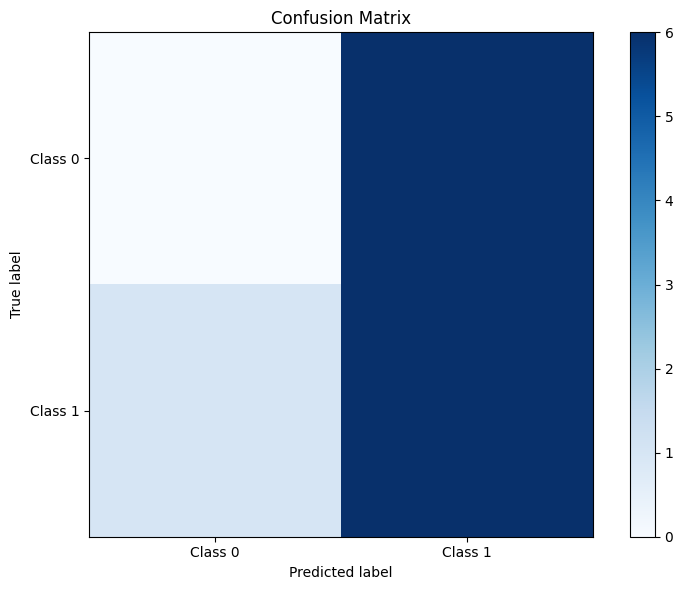

In [ ]:
final_model = RandomForestClassifier(n_estimators=100)
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_val)
cm_final = confusion_matrix(y_val, y_pred_final)
plot_confusion_matrix(cm_final, classes=['Class 0', 'Class 1'])